# Combining Sentiment Analysis and Identifying Keywords With Topics

The <b> purpose</b> of this notebook is to combine sentiment analysis from prior notebooks and identify keywords from text and titles. The <b> results</b> will be inputted into the Twitter API search feature, but we need to be able to create specific topics to do so. 

## Libraries

In [382]:
import pandas as pd
import numpy as np
from pprint import pprint
import datetime
import spacy
import json
import os
import matplotlib.pyplot as plt
import matplotlib
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import models
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
import pyLDAvis.gensim
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/celinasprague/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Datasets From Prior Notebook

### Sentiment Analysis Data

The <b> "polar_data"</b> file contains polarization and sentiment columns calculated using "Textblob." The <b> "vedar_data</b> file contains only sentiment analysis run through vedar. 

In [3]:
polar_data = pd.read_csv('sentimentdata.csv')
vedar_data = pd.read_csv('vedardata.csv')

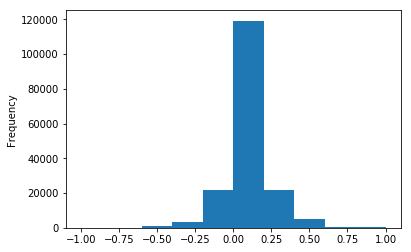

In [71]:
polar_data['polarity'].plot.hist()

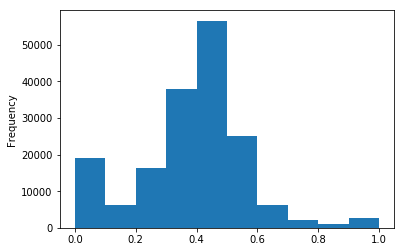

In [73]:
polar_data['subjectivity'].plot.hist()

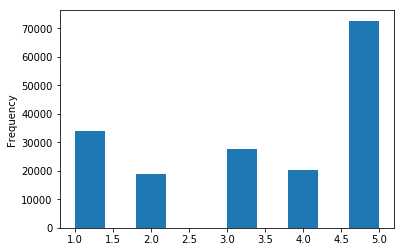

In [75]:
vedar_data['SENTIMENT_VALUE'].plot.hist()

Unfortunately, sentiment analysis here doesn't look too promising, so we'll keep it on the bookshelf for now and focus on NLP.

### NLP

In [86]:
data = pd.read_csv('finaldata.csv', dtype = str)

In [87]:
data = data.drop(columns=['Unnamed: 0'])

In [254]:
data.head()

,author,crawled,entities_locations,entities_organizations,entities_persons,external_links,highlightText,highlightTitle,language,locations,...,thread_social_vk_shares,thread_spam_score,thread_title,thread_title_full,thread_url,thread_uuid,title,url,uuid,thread_domain_rank
0,USNews,2015-10-02T17:33:59.981+03:00,NaN,NaN,NaN,[['http://www.reddit.com/submit?url=http%3A%2F...,NaN,NaN,english,NaN,...,0,0.0,The Healthiest Pastas: From Quinoa to Buckwhea...,The Healthiest Pastas: From Quinoa to Buckwhea...,http://health.usnews.com/health-news/health-we...,8085f289866a814f7a443e1a31e48f8a307a040f,The Healthiest Pastas: From Quinoa to Buckwhea...,http://health.usnews.com/health-news/health-we...,8085f289866a814f7a443e1a31e48f8a307a040f,NaN
1,NaN,2015-10-19T09:23:00.540+03:00,NaN,NaN,NaN,NaN,NaN,NaN,english,['Savoonga'],...,0,0.0,Photos: Operation Santa Claus visits Savoonga,Photos: Operation Santa Claus visits Savoonga,http://www.newsdump.com/article/photos-operati...,f4ad43deab0a72726d6165b37a971c578efdd4f5,Photos: Operation Santa Claus visits Savoonga,http://www.newsdump.com/article/photos-operati...,f4ad43deab0a72726d6165b37a971c578efdd4f5,NaN
2,NaN,2015-10-08T17:42:28.717+03:00,NaN,NaN,NaN,NaN,NaN,NaN,english,['Palmyra'],...,0,0.0,"Watch: Video Shows 2,000-Year-Old Ancient Arch...","Watch: Video Shows 2,000-Year-Old Ancient Arch...",http://www.newsdump.com/article/watch-video-sh...,c98cbd870f52950ff685e772fd189bd01fc85767,"Watch: Video Shows 2,000-Year-Old Ancient Arch...",http://www.newsdump.com/article/watch-video-sh...,c98cbd870f52950ff685e772fd189bd01fc85767,NaN
3,NaN,2015-10-05T10:10:00.218+03:00,NaN,NaN,NaN,NaN,NaN,NaN,english,NaN,...,0,0.0,'Fear the Walking Dead' ends Season 1 on a gri...,'Fear the Walking Dead' ends Season 1 on a gri...,http://www.newsdump.com/article/fear-the-walki...,3481ad311613e0da31e6017f854c7ded093b398a,'Fear the Walking Dead' ends Season 1 on a gri...,http://www.newsdump.com/article/fear-the-walki...,3481ad311613e0da31e6017f854c7ded093b398a,NaN
4,NaN,2015-10-23T15:40:06.454+03:00,NaN,NaN,NaN,NaN,NaN,NaN,english,NaN,...,0,0.0,Facebook app draining your iPhone battery? Com...,Facebook app draining your iPhone battery? Com...,http://www.newsdump.com/article/facebook-app-d...,17954912c005732967b28ef81b4ebc58d3911efc,Facebook app draining your iPhone battery? Com...,http://www.newsdump.com/article/facebook-app-d...,17954912c005732967b28ef81b4ebc58d3911efc,NaN


In [88]:
data_colnan=data.columns[data.isnull().any()]
data[data_colnan].isnull().sum()

author                                76379
entities_locations                   109139
entities_organizations               105393
entities_persons                     104007
external_links                       157547
highlightText                        170880
highlightTitle                       170880
locations                            153104
organizations                        145141
persons                              153170
text                                    361
thread_country                          657
thread_main_image                     53661
thread_participants_count              2433
thread_performance_score               2433
thread_published                       2433
thread_replies_count                   2433
thread_section_title                  27551
thread_site                            2433
thread_site_full                       2433
thread_site_section                   25529
thread_site_type                       4866
thread_social_facebook_comments 

In [89]:
data['title'] = data['title'].fillna("none")
data['text'] = data['text'].fillna("none")

## Setting Up NLP Helper Functions

In [10]:
count_vec = CountVectorizer()
X_train_count = count_vec.fit_transform(data.text)

In [11]:
lemtzer = WordNetLemmatizer()

def lemmatize_stemming(text):
    return lemtzer.lemmatize(text, pos='v')

# Write a function to perform the pre processing steps on the entire dataset
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
            
    return result

## NLP on Text

The following cells are creating inputs used for "Out of Bag" and term frequency–inverse document frequency (TF-IDF).

#### WARNING! 
The code below takes some time to run. 

In [188]:
counter = 0
start_time = time.time()

processed_docs  = []

for doc in data.text:
    processed_docs.append(preprocess(doc))
    
    counter += 1
    
    if counter % 10000 == 0:
        print("There have been {} files read so far".format(counter))
        print("Time elapsed: {}".format(time.time() - start_time))
        
    
print("Operation complete after {} seconds.".format(time.time()-start_time))   

There have been 10000 files read so far
Time elapsed: 13.740357875823975
There have been 20000 files read so far
Time elapsed: 25.766791105270386
There have been 30000 files read so far
Time elapsed: 37.314584255218506
There have been 40000 files read so far
Time elapsed: 47.74872803688049
There have been 50000 files read so far
Time elapsed: 58.844062089920044
There have been 60000 files read so far
Time elapsed: 70.20023703575134
There have been 70000 files read so far
Time elapsed: 81.75191307067871
There have been 80000 files read so far
Time elapsed: 94.13716697692871
There have been 90000 files read so far
Time elapsed: 136.832622051239
There have been 100000 files read so far
Time elapsed: 176.52862405776978
There have been 110000 files read so far
Time elapsed: 217.19162917137146
There have been 120000 files read so far
Time elapsed: 264.3173460960388
There have been 130000 files read so far
Time elapsed: 307.7169511318207
There have been 140000 files read so far
Time elapsed: 

In [189]:
dictionary = gensim.corpora.Dictionary(processed_docs)

Setting parameters for our tokens - removing words occuring more or less than criteria and retaining most frequent tokens based on a threshold. 

In [190]:
dictionary.filter_extremes(no_below=15, no_above=0.2, keep_n=50000)

We're formatting for "out-of-bag."

In [191]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## LDA Model "Out of Bag" on Text

In [48]:
%%time
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, id2word=dictionary, passes=2)
lda_model.save('lda.model')

CPU times: user 6min 34s, sys: 1min 24s, total: 7min 59s
Wall time: 9min 34s


In [49]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.086*"pm" + 0.065*"vs" + 0.051*"nbcsn" + 0.047*"csn" + 0.031*"nba" + 0.030*"et" + 0.030*"pt" + 0.028*"golf" + 0.027*"wed" + 0.021*"digital"

Topic: 1 Word: 0.017*"tax" + 0.013*"pay" + 0.012*"million" + 0.011*"budget" + 0.010*"price" + 0.010*"money" + 0.009*"cost" + 0.009*"percent" + 0.009*"increase" + 0.009*"cut"

Topic: 2 Word: 0.071*"sign" + 0.050*"email" + 0.033*"account" + 0.032*"send" + 0.029*"link" + 0.026*"privacy" + 0.024*"click" + 0.021*"register" + 0.020*"check" + 0.020*"receive"

Topic: 3 Word: 0.014*"gay" + 0.013*"rodeo" + 0.009*"pipeline" + 0.007*"speech" + 0.007*"right" + 0.007*"night" + 0.006*"saturday" + 0.006*"stand" + 0.006*"concert" + 0.005*"image"

Topic: 4 Word: 0.008*"power" + 0.008*"world" + 0.006*"political" + 0.005*"think" + 0.004*"government" + 0.004*"country" + 0.004*"ireland" + 0.004*"right" + 0.004*"view" + 0.004*"bank"

Topic: 5 Word: 0.022*"ticket" + 0.014*"conway" + 0.012*"stone" + 0.012*"ft" + 0.010*"rm" + 0.010*"financial" + 0.010*"debb

### Quick Visualization

In [50]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
43    -0.015542  0.002385       1        1  10.828598
35    -0.049935 -0.169742       2        1   4.298453
45     0.064937  0.025508       3        1   4.286391
8     -0.130751 -0.084192       4        1   3.976311
1     -0.098499 -0.107094       5        1   3.824869
33    -0.098703 -0.032901       6        1   3.180555
25    -0.123558  0.122455       7        1   3.163073
26    -0.074434  0.154570       8        1   2.724612
30     0.063434 -0.060944       9        1   2.664290
19    -0.113675 -0.105869      10        1   2.617362
46     0.002036 -0.090139      11        1   2.615227
4     -0.109731 -0.031857      12        1   2.570260
9      0.075011  0.038943      13        1   2.461503
31    -0.069524 -0.157470      14        1   2.446244
14    -0.071201 -0.078273      15        1   2.440814
42    -0.105128 -0.026118      16        1   2.439306
28    -0.096789  0.063894      17        1   2.287412
47    -0.017891 -0.042643      18        1   2.254238
37    -0.033756 -0.176960      19        1   2.233784
29    -0.132892 -0.024511      20        1   2.198038
10    -0.060654 -0.111878      21        1   2.100230
7     -0.003266 -0.123225      22        1   2.062294
49    -0.054300 -0.005832      23        1   2.052603
20    -0.118474  0.101537      24        1   1.984808
0      0.410425 -0.032611      25        1   1.845440
41     0.054139 -0.001783      26        1   1.827518
23    -0.098364  0.044832      27        1   1.740623
39    -0.075226  0.151562      28        1   1.704536
48    -0.059506  0.185342      29        1   1.524797
21    -0.020099 -0.019968      30        1   1.487653
40    -0.071239 -0.047819      31        1   1.484611
34    -0.071503  0.085840      32        1   1.178234
27    -0.050514  0.021720      33        1   1.144707
24     0.022843 -0.047036      34        1   1.105726
44     0.000143 -0.047936      35        1   1.026416
2      0.092941  0.135397      36        1   0.926539
17     0.071119  0.039718      37        1   0.922984
36     0.151963  0.051997      38        1   0.908277
12    -0.043615  0.026981      39        1   0.885339
15    -0.064435  0.019783      40        1   0.788051
3     -0.040392  0.133988      41        1   0.745857
22     0.013726  0.067975      42        1   0.743975
13    -0.040174  0.134406      43        1   0.707070
11     0.085215 -0.057398      44        1   0.660934
6      0.245767  0.017677      45        1   0.637750
38     0.342947 -0.030976      46        1   0.631011
32     0.104221 -0.080544      47        1   0.473876
5      0.034636  0.045983      48        1   0.440351
18     0.064575  0.112609      49        1   0.430151
16     0.313695  0.010619      50        1   0.316295, topic_info=      Category           Freq           Term          Total  loglift  logprob
term                                                                         
1546   Default  114247.000000          trump  114247.000000  30.0000  30.0000
614    Default   71178.000000             pm   71178.000000  29.0000  29.0000
213    Default   46486.000000         school   46486.000000  28.0000  28.0000
4244   Default   38030.000000             vs   38030.000000  27.0000  27.0000
762    Default   48523.000000         police   48523.000000  26.0000  26.0000
910    Default   81765.000000      president   81765.000000  25.0000  25.0000
594    Default   30453.000000             mr   30453.000000  24.0000  24.0000
18943  Default   27479.000000          nbcsn   27479.000000  23.0000  23.0000
931    Default   38428.000000           sign   38428.000000  22.0000  22.0000
461    Default   75649.000000          house   75649.000000  21.0000  21.0000
1159   Default   44209.000000          party   44209.000000  20.0000  20.0000
102    Default   38015.000000         health   38015.000000  19.0000  19.0000
30134  Default   27607.000000            csn   27607.0000

## LDA TF-IDF on Text

We're going to run another LDA model, but now we want to gain a sense of how important a word is to the document. 

In [51]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [52]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, num_topics=50, id2word=dictionary, passes=2)
lda_model_tfidf.save('lda_tfidf.model')

CPU times: user 13min 16s, sys: 1min 35s, total: 14min 51s
Wall time: 16min 54s


In [53]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"government" + 0.003*"mr" + 0.003*"court" + 0.002*"tax" + 0.002*"minister" + 0.002*"financial" + 0.002*"westminster" + 0.002*"bank" + 0.002*"uk" + 0.002*"pay"
Topic: 1 Word: 0.011*"cricket" + 0.011*"test" + 0.009*"india" + 0.009*"australia" + 0.009*"apple" + 0.009*"iphone" + 0.008*"kong" + 0.006*"hong" + 0.006*"smith" + 0.006*"bat"
Topic: 2 Word: 0.008*"google" + 0.006*"company" + 0.005*"amazon" + 0.005*"app" + 0.004*"users" + 0.004*"water" + 0.004*"use" + 0.003*"tech" + 0.003*"browser" + 0.003*"car"
Topic: 3 Word: 0.048*"article" + 0.035*"relate" + 0.034*"story" + 0.030*"read" + 0.015*"recommend" + 0.012*"oct" + 0.012*"interest" + 0.010*"westbrook" + 0.008*"oops" + 0.007*"buffalow"
Topic: 4 Word: 0.021*"spicer" + 0.015*"rm" + 0.014*"ncaa" + 0.011*"seed" + 0.006*"kentucky" + 0.006*"malaysiakini" + 0.005*"phoenix" + 0.005*"arizona" + 0.005*"reynolds" + 0.005*"bloom"
Topic: 5 Word: 0.020*"korea" + 0.015*"missile" + 0.014*"jong" + 0.013*"korean" + 0.012*"yogi" + 0.011

In [56]:
pyLDAvis.gensim.prepare(lda_model_tfidf, tfidf_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.258407 -0.053830       1        1  11.715462
46     0.210510  0.115931       2        1   8.893634
6      0.226613 -0.019586       3        1   7.343977
13     0.224443 -0.010372       4        1   6.157769
16     0.175881  0.005653       5        1   5.248522
7      0.218034 -0.063693       6        1   5.038418
45     0.195113  0.043322       7        1   4.726753
23     0.173180 -0.085996       8        1   3.795943
30     0.179535  0.021296       9        1   3.700672
33     0.181195 -0.088222      10        1   3.426868
38     0.107166  0.243548      11        1   2.544848
2      0.118771 -0.063617      12        1   2.332471
9      0.112296 -0.002622      13        1   2.172102
37     0.123157 -0.063565      14        1   1.870651
32     0.094172 -0.111483      15        1   1.538760
10     0.071970 -0.039799      16        1   1.505590
11     0.095530  0.097581      17        1   1.469702
15     0.057114 -0.045948      18        1   1.305564
14    -0.008176  0.004172      19        1   1.166083
49    -0.054769  0.017666      20        1   1.164622
44    -0.013906  0.151841      21        1   1.163708
1      0.041512  0.083263      22        1   1.160437
4     -0.044148  0.066530      23        1   1.041021
35    -0.045242 -0.079596      24        1   1.038272
3     -0.096112  0.102467      25        1   1.032037
48    -0.061128  0.043485      26        1   0.938004
40    -0.048257  0.035679      27        1   0.921216
41    -0.057783 -0.003166      28        1   0.920804
43    -0.096531 -0.058380      29        1   0.895450
8     -0.021705 -0.109839      30        1   0.869452
39    -0.059736  0.164966      31        1   0.859420
20    -0.053632 -0.050836      32        1   0.821173
29    -0.017633  0.074683      33        1   0.786202
34    -0.098217 -0.041175      34        1   0.755372
5     -0.087434 -0.075633      35        1   0.753283
42    -0.096393 -0.067415      36        1   0.695967
24    -0.079961 -0.073946      37        1   0.659906
12    -0.148818 -0.009047      38        1   0.654779
47    -0.115047  0.068366      39        1   0.651809
17    -0.112216 -0.028764      40        1   0.642341
21    -0.106024  0.056569      41        1   0.641691
19    -0.142571 -0.041791      42        1   0.605650
18    -0.133163 -0.021431      43        1   0.580528
28    -0.108005  0.014362      44        1   0.579857
25    -0.124660 -0.014343      45        1   0.571732
27    -0.164728 -0.061374      46        1   0.565308
31    -0.162685 -0.008777      47        1   0.560958
26    -0.162024  0.019017      48        1   0.527025
22    -0.161612 -0.019342      49        1   0.511943
36    -0.182283 -0.016807      50        1   0.476252, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
1546   Default  2968.000000        trump  2968.000000  30.0000  30.0000
295    Default  1155.000000      article  1155.000000  29.0000  29.0000
308    Default   964.000000        story   964.000000  28.0000  28.0000
192    Default  1072.000000         read  1072.000000  27.0000  27.0000
306    Default   842.000000       relate   842.000000  26.0000  26.0000
762    Default  1375.000000       police  1375.000000  25.0000  25.0000
5167   Default   478.000000           eu   478.000000  24.0000  24.0000
931    Default   913.000000         sign   913.000000  23.0000  23.0000
102    Default   987.000000       health   987.000000  22.0000  22.0000
973    Default   718.000000       online   718.000000  21.0000  21.0000
1076   Default   755.000000        email   755.000000  20.0000  20.0000
88     Default  1067.000000         game  1067.000000  19.0000  19.0000
20052  Default   406.000000       brexit   406.000000  18.0000  18.0000
336    Default   706.000000      clinton   706.000000  17.0000  17.00

## Subsetting By Topic

In [92]:
data.columns.tolist()

['author',
 'crawled',
 'entities_locations',
 'entities_organizations',
 'entities_persons',
 'external_links',
 'highlightText',
 'highlightTitle',
 'language',
 'locations',
 'ord_in_thread',
 'organizations',
 'persons',
 'published',
 'text',
 'thread_country',
 'thread_main_image',
 'thread_participants_count',
 'thread_performance_score',
 'thread_published',
 'thread_replies_count',
 'thread_section_title',
 'thread_site',
 'thread_site_full',
 'thread_site_section',
 'thread_site_type',
 'thread_social_facebook_comments',
 'thread_social_facebook_likes',
 'thread_social_facebook_shares',
 'thread_social_gplus_shares',
 'thread_social_linkedin_shares',
 'thread_social_pinterest_shares',
 'thread_social_stumbledupon_shares',
 'thread_social_vk_shares',
 'thread_spam_score',
 'thread_title',
 'thread_title_full',
 'thread_url',
 'thread_uuid',
 'title',
 'url',
 'uuid',
 'thread_domain_rank']

Selecting columns to be included in the subset dataframe.

In [94]:
data_subset = data[["title","text", "published", "thread_social_facebook_comments", "thread_social_facebook_likes", "thread_social_facebook_shares", "thread_social_gplus_shares", "thread_social_linkedin_shares", "thread_social_pinterest_shares", "thread_social_stumbledupon_shares", "thread_social_vk_shares", "thread_spam_score"]]

List of keywords from the LDA analysis.

In [99]:
keys = ['trump','opp','hannity','aaec','suresh','pwc','ţńçáé','karan','flynn','apos','starbucks','brisbane','wilders','romo','meddle','rutte','lionel','feldman','ensemble','johar','baahubali','robredo','thames','christchurch','bharara','rockefeller','enquirer','zuckerberg','maddow','wolverine','dortmund','belfast','molina','gif','ellwood','burr','vols','flavour','mow','mesut','rhinos','giraffe','fatty','supernatural','inquest','markle','meghan','bhatt','dh','cbo','zuma','paedophile','thaad','bmw','samsung','oscars','najib','wrestlemania','wwe','schwarzenegger','ng','collusion','bitcoin','tebow','zayn','moran','slug','csn','gonzaga','leggings','birdie','tata','vaccine','romeo','pujara','jadeja','bale','melania','apr','kangana','phillauri','tottenham','cyclone','atletico','efl','goalkeeper','subscriber','kushner','nike','bayern','lago','akshay','deepika','suarez','spicer','rm','westbrook','buffalow','dinosaurs','oops','durant','gosling','screengrab','raiders','wickets','ranchi','psg','bcci','overs','iframe','cornerback','gaikward','pune','barkley','loginwidget','marsh','spotify','ronaldo','cristiano','luggage','amarinder','zee','fuller','mandela','nunes','wenger','mourinho','mgr','kohli','nbcsn','messi','arsene','manila','trudeau','masood','kalanick','href','chappelle','johansson','nokia','cancers','opioids','thrash','manitoba','quebec','halifax','fis','ndp','sheeren','haye','nicki','minaj','hanson','bellew','','rocketnews','hijab','cnet','monaco','fifa','gunners','pogba','zlatan','iraqi','mosul','bjp','uttar','modi','pradesh','rostov','kuala','lumpur','fullscreen','kejriwal','spacex','bacteria','recuse','federer','detectives','pedestrians','pupils','lgbt','comey','wiretapping','brexit','vaccine','tata','vaccine','tesla','trudeau','westminster','clinton', 'health', 'korea', 'police', 'policy', 'obamacare', 'kaepernick', 'biden', 'comey', 'lgbtq', 'transgender', 'trans', 'gorsuch', 'pedestrians']    



Some light cleaning to account for human error, i.e., duplicates, spaces, blanks.

In [104]:
keys = list(filter(None, keys))

Final set of keywords.

In [304]:
keys_clean = list(set(keys))

In [163]:
keys_df = pd.DataFrame(keys_clean)

In [171]:
keys_df = keys_df.rename(index=str, columns={0: "Keywords",})

In [398]:
keys_df

,Keywords
0,korea
1,vols
2,obamacare
3,zlatan
4,trans
5,buffalow
6,dortmund
7,zuma
8,bmw
9,screengrab


Dataframe containing keywords in the text.

In [350]:
subset_df = data_subset[~data_subset['text'].str.contains('|'.join(keys_clean))].reset_index(drop=True)

In [351]:
subset_df['length'] = subset_df['published'].apply(lambda x: len(x))
cond = subset_df['length'] < 40
data2 = subset_df[cond]

In [353]:
data2['published'] = data2['published'].str[:10]

In [355]:
data2['text'] = data2['text'].str.lower()

In [361]:
data2 = data2.drop(columns='length')

## Categorizing News

Grouping into the news articles into the following categories:
- <b>Extreme:</b> Low frequency, high shares
- <b>Controversial:</b> High frequency, high shares
- <b>Baseline:</b> Low frequency, low shares
- <b>Other:</b> High frequency, low shares

### This is a pseudo dynamic way of seeing count of articles by keywork/topic over time. 
Note the <b>Plotly</b> graph will open in a new window and you can zoom in to see curve. 

In [431]:
topic = data2[(data2['text'].str.contains('school')) & (data2['text'].str.contains('police')) | (data2['text'].str.contains('black'))].reset_index(drop=True)

In [432]:
topic

,title,text,published,thread_social_facebook_comments,thread_social_facebook_likes,thread_social_facebook_shares,thread_social_gplus_shares,thread_social_linkedin_shares,thread_social_pinterest_shares,thread_social_stumbledupon_shares,thread_social_vk_shares,thread_spam_score
0,Four hurt in Blackford County crash,published by: the star press - today \nfour pe...,2015-10-14,0,0,0,0,0,0,0,0,0.0
1,"Delaware’s deepest, darkest nightmare",published by: delaware online: opinion - today...,2015-10-17,0,0,0,0,0,0,0,0,0.0
2,Potential Threats Against Ashland High School ...,( source : ashland police department ) city of...,2015-10-05,0,0,0,0,0,0,0,0,0.0
3,Toews scores in OT to lift Blackhawks past Isl...,published by: beaumont enterprise: sports - to...,2015-10-10,0,0,0,0,0,0,0,0,0.0
4,BlackBerry may leave the handset market if it ...,blackberry may leave the handset market if it ...,2015-10-09,0,0,0,0,0,0,0,0,0.0
5,Obama on #BlackLivesMatter: Of Course All Live...,published by: media ite - today \npresident ob...,2015-10-23,0,0,0,0,0,0,0,0,0.0
6,Sprint Black Friday 2015 Ad: Find the Best Spr...,sprint black friday 2015 ad: find the best spr...,2015-10-24,0,0,0,0,0,0,0,0,0.0
7,Why the black Whopper turns your poop green,published by: usatoday.com: nation - today \nb...,2015-10-09,0,0,0,0,0,0,0,0,0.0
8,IKEA Black Friday 2015 Ad – Find the Best IKEA...,ikea black friday 2015 ad – find the best ikea...,2015-10-21,0,0,0,0,0,0,0,0,0.0
9,"In memoriam: David Russell, professor of mathe...",( source : virginia tech - virginia polytechni...,2015-10-08,0,0,0,0,0,0,0,0,0.0


In [433]:
graph = topic.groupby(['published']).size().reset_index(name='counts')

In [434]:
graph

,published,counts
0,2015-10-01,3
1,2015-10-02,2
2,2015-10-03,2
3,2015-10-05,6
4,2015-10-08,6
5,2015-10-09,16
6,2015-10-10,8
7,2015-10-12,7
8,2015-10-13,7
9,2015-10-14,16


In [435]:
init_notebook_mode(connected=True)

In [436]:
import plotly
import plotly.graph_objs

plotly.offline.plot({
"data": [
    plotly.graph_objs.Bar(x=graph['published'],y=graph['counts'])
]
})

'file:///Users/celinasprague/Desktop/Data Science School/NYC Data Science Academy/Projects/Capstone/Capstone-general-Illusion-effect/Notebooks/temp-plot.html'

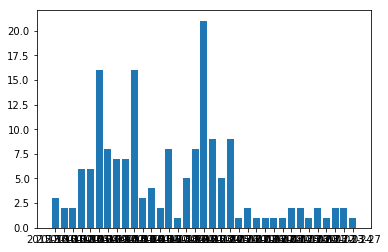

In [437]:
plt.bar(graph['published'], graph['counts'])

plt.show()

# End